For this different maze our code can only be slightly adjusted for possible actions at state u1 as well as rewards associated with actions at each state.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#initialize a class for our environment

class Maze2:
    def __init__(self):

        # Define states, actions, rewards, predictions (v), action values, action probabilities
        self.states = ['u1', 'u2', 'u3']
        self.actions = {'u1': ['L', 'R'],
                        'u2': ['L', 'R'],
                        'u3': ['L', 'R']}
        self.rewards = {'u1': {'L': 0, 'R': 0},
                        'u2': {'L': 4, 'R': 0},
                        'u3': {'L': 2, 'R': 3}}
        self.action_values = {'u1': {'L': 0, 'R': 0},
                              'u2': {'L': 0, 'R': 0},
                              'u3': {'L': 0, 'R': 0}}
        self.action_probabilities = {'u1': {'L': 1/2, 'R': 1/2},
                                     'u2': {'L': 1/2, 'R': 1/2},
                                     'u3': {'L': 1/2, 'R': 1/2}}
        self.state_prediction = {'u1': 0, 'u2': 0, 'u3': 0}

    # Define update action values function
    def update_action_values(self, state, action, delta, Actor_critic):
        if Actor_critic == True: #update action values only for actor-critic model
            self.action_values[state][action] = (1-decay_constant)*self.action_values[state][action] + actor_l_r*delta
        return (self.action_values[state][action])

    # define update probabilities function

    def update_probabilities(self, state, Actor_critic):
        if Actor_critic == True: #update probabilities only for actor-critic model
            # Get available actions for the state
            available_actions = self.actions[state]
            # Consider only available actions
            action_values = {
                a: self.action_values[state][a] for a in available_actions}
            exp_values = np.exp(beta * np.array(list(action_values.values())))
            total = np.sum(exp_values)
            probabilities = exp_values / total

            for action, prob in zip(available_actions, probabilities):
                self.action_probabilities[state][action] = prob

    #define take action function
    def take_action(self, state):
        action = np.random.choice(list(self.actions[state]), p=list(self.action_probabilities[state].values()))
        return action

    def update_predictions(self, state, learning_rate,delta):
        self.state_prediction[state] += learning_rate*delta
        return self.state_prediction

    # define restore to inital parameters function

    def restore(self):

        self.action_values = {'u1': {'L': 0, 'R': 0},
                              'u2': {'L': 0, 'R': 0},
                              'u3': {'L': 0, 'R': 0}}
        self.action_probabilities = {'u1': {'L': 1/2, 'R': 1/2},
                                     'u2': {'L': 1/2, 'R': 1/2},
                                     'u3': {'L': 1/2, 'R': 1/2}}
        self.state_prediction = {'u1': 0, 'u2': 0, 'u3': 0}

    #define the function that runs our environment
    def run_maze(self, beta, decay_constant, actor_l_r, learning_rate, experiments, Trials):   
        
        #initialize arrays to store our data for plotting
        w_states = np.zeros((experiments, Trials, 3))
        probabilities_states = np.zeros((experiments, Trials, 3, 3))
        
        for experiment in range(experiments):
            self.restore() #restore environment to initial parameters
            
            for trial in range(Trials):

                state = 'u1' #initialize state
                action = self.take_action(state) #take action
                reward = self.rewards[state][action] #get reward
                self.update_probabilities(state,Actor_critic) #update probabilities

                if action in ['R', 'L']:
                    delta = reward - self.state_prediction[state] #calculate delta

                    self.update_predictions(state, learning_rate,delta) #update predictions
                    self.update_action_values(state, action, delta, Actor_critic) #update action values
                    self.update_probabilities(state, Actor_critic) #update probabilities

                
                    new_state = np.random.choice(['u2', 'u3']) #choose new state probabilistically
                    delta = reward + self.state_prediction[new_state] - self.state_prediction[state] #calculate delta

                    self.update_predictions(state, learning_rate,delta) #update predictions
                    self.update_action_values(state, action, delta, Actor_critic) #update action values
                    self.update_probabilities(state, Actor_critic) #update probabilities

                    state = new_state #update state
                    action = self.take_action(state) #take action in new state
                    reward = self.rewards[state][action] #get reward in new state
                    delta = reward - self.state_prediction[state] #calculate delta in new state

                    self.update_predictions(state, learning_rate,delta) #update predictions in new state
                    self.update_action_values(state, action, delta, Actor_critic) #update action values in new state
                    self.update_probabilities(state, Actor_critic) #update probabilities in new state

                #store data for plotting
                for i in range(len(list(self.states))):
                    for k in range(len(list(self.actions[self.states[i]]))):
                        probabilities_states[experiment, trial, i,
                                            k] = self.action_probabilities[self.states[i]][self.actions[self.states[i]][k]]
                    w_states[experiment, trial, i] = self.state_prediction[self.states[i]]

        return probabilities_states, w_states
    

In [2]:
#define fuction to run the simulation and plot results
def plot_results():
    
    probabilities_states, w_states = env.run_maze(beta, decay_constant, actor_l_r, learning_rate, experiments, Trials)
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=False,sharex='col')
    styles = ['--', '', ':']

    for i in range(len(list(env.states))):
        for k in range(len(list(env.actions[env.states[i]]))):
            axs[1, i].plot(np.average(probabilities_states[:, :, i, k], axis=0), styles[k], label= env.actions[env.states[i]][k])
            if i == 0:
                axs[1, i].set_ylabel('P[a|u]', fontsize=14) 
            axs[1, i].legend(title='average across experiments')
            axs[1, i].set_xlabel('Trials', fontsize=14)


    for i in range(len(list(env.states))):
        axs[0, i].set_title(f'State = {env.states[i]}', fontsize=14)
        axs[0, i].plot(np.average(w_states[:, :, i], axis=0),label='average across experiments')
        axs[0, i].plot(w_states[np.random.randint(0, 500), :, i], 'k:', label='random experiment')
        
        axs[0, i].set_ylabel('v(u)', fontsize=14)
        axs[0, i].legend(loc='lower right')

    


    axs[0][0].axhline(y=3.5, color='r', linestyle='--', label='optimal policy')
    axs[0][0].axhline(y=2.25, color='g', linestyle='--', label='equiprobable policy')   
    axs[0][0].legend(loc='lower right')
    
    axs[0][1].axhline(y=4, color='r', linestyle='--' , label='optimal policy ')
    axs[0][1].axhline(y=2, color='g', linestyle='--', label='equiprobable policy')   
    axs[0][1].legend(loc='lower right')
    axs[0][2].axhline(y=3, color='r', linestyle='--', label='optimal policy')
    axs[0][2].axhline(y=2.5, color='g', linestyle='--', label='equiprobable policy')   
    axs[0][2].legend(loc='lower right')
    
    plt.tight_layout()  
    plt.show()


Let's simulate with the same parameters as before

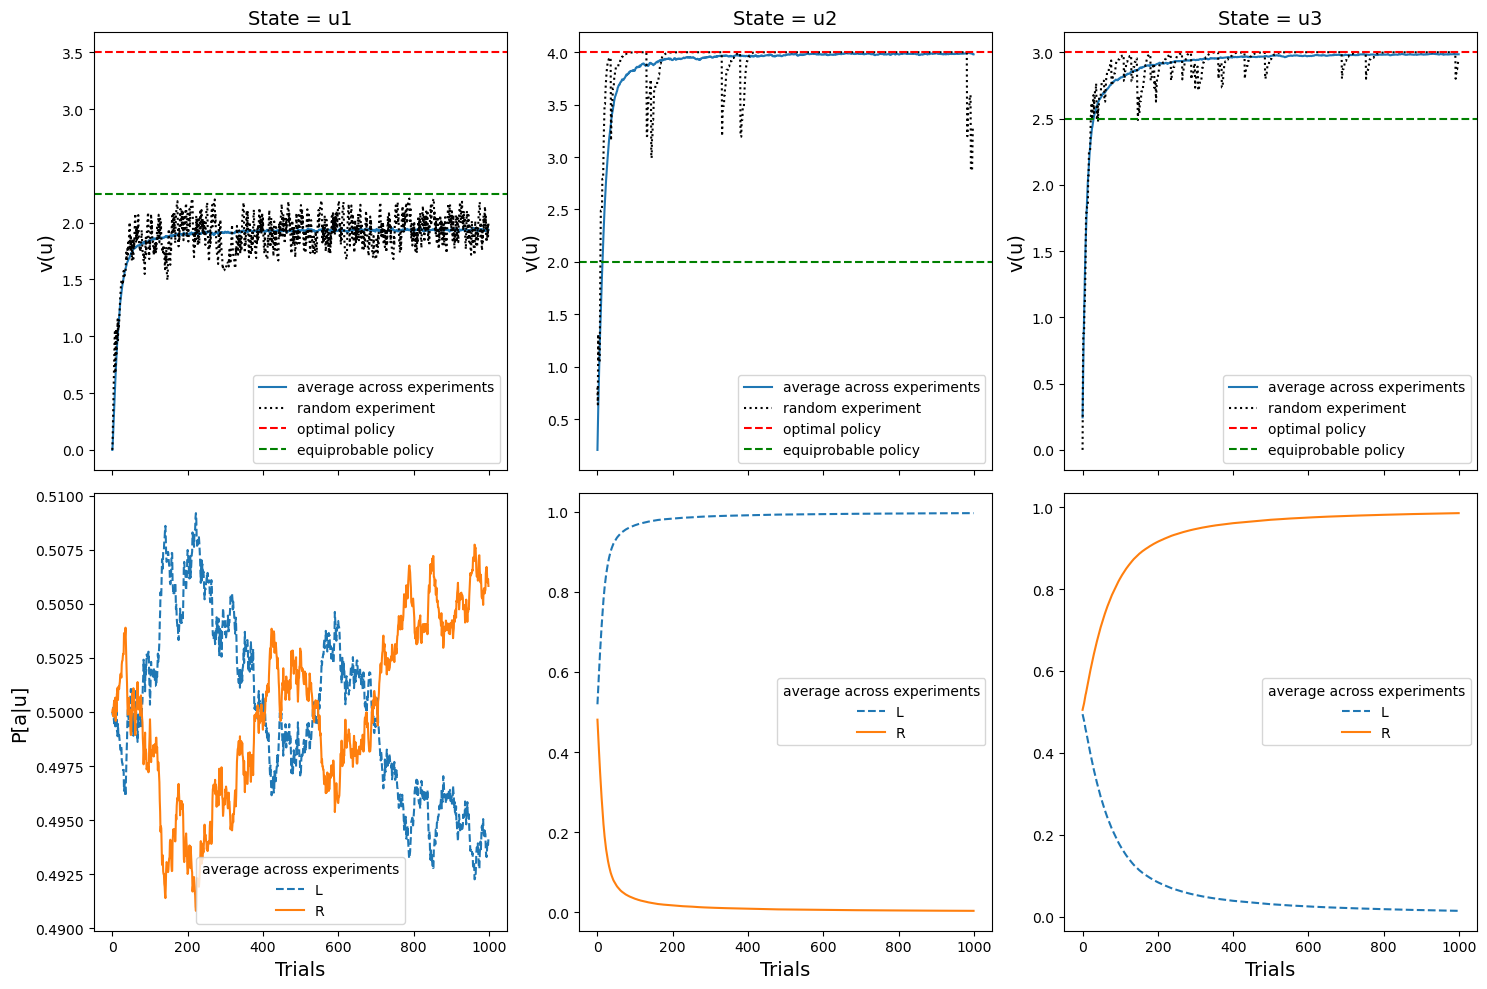

In [3]:
#set parameters
beta = 1
decay_constant = 0
actor_l_r = 0.075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = True
env=Maze2()
#run simulation and plot results
plot_results()


We can see that the process is more stochastic. Within the 1000 trials there are periods where 'L' is more probable than 'R' and vice versa. Moreover, if we run the simulation again, we can get a totally different outcome (see below). This is because the maximal reward, having chosen 'L' or 'R' is very similar: 4 and 3 respectively. Overal, with comparable rewards, the choice seems to be more determined by chance rather than by previous experience.

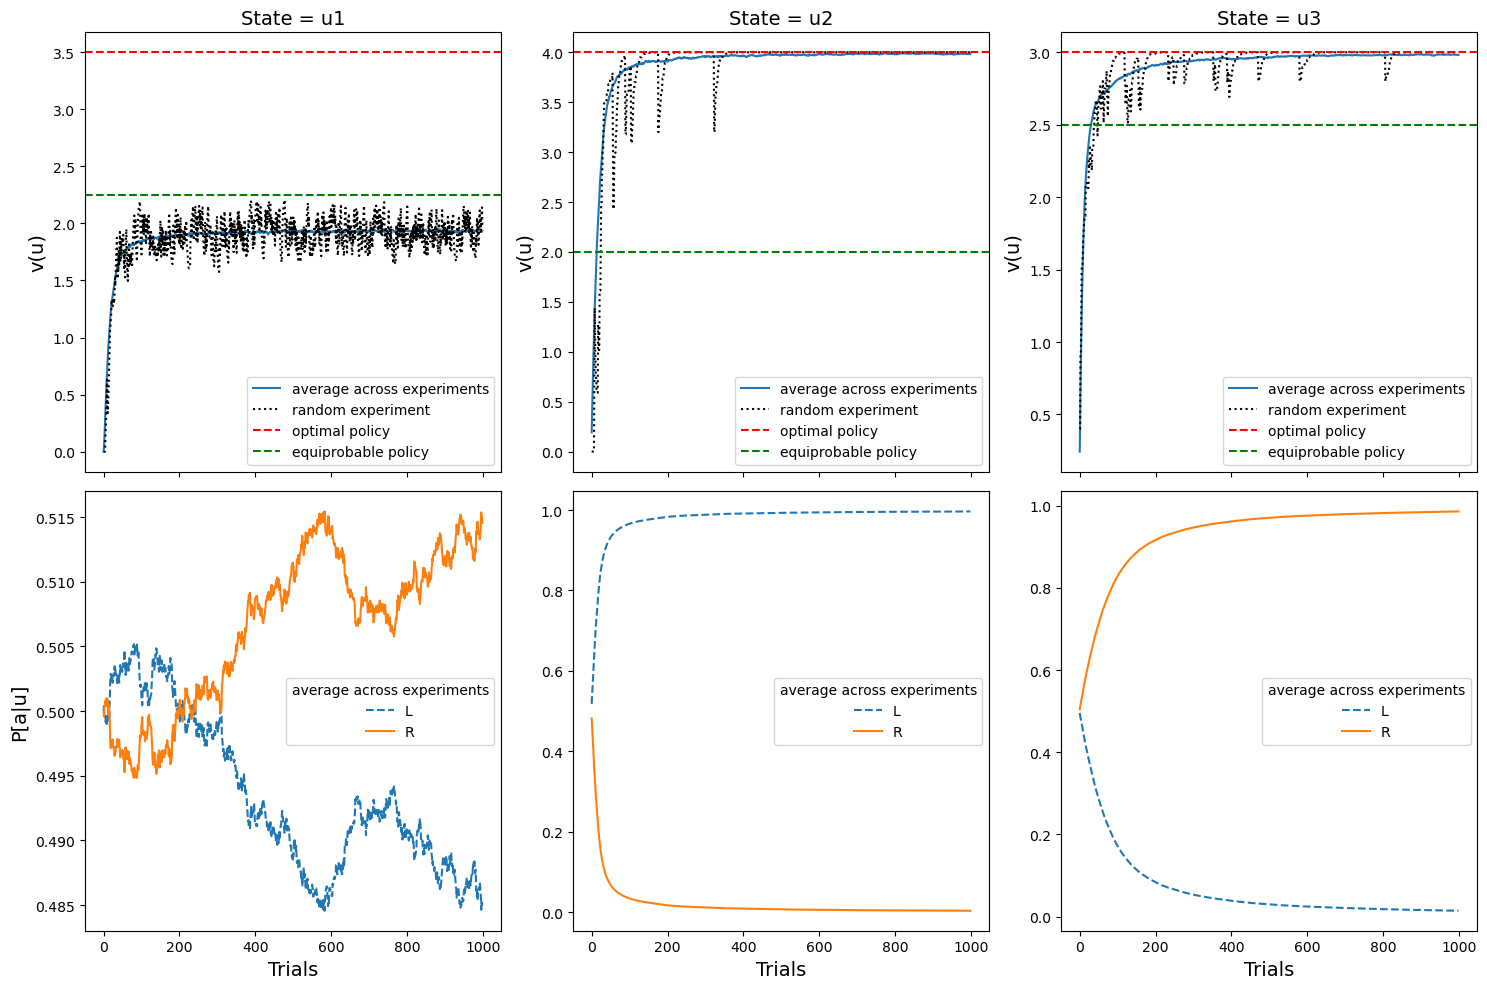

In [4]:
#set parameters
beta = 1
decay_constant = 0
actor_l_r = 0.075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = True
env=Maze2()
#run simulation and plot results
plot_results()
